In [1]:
import os
from importlib.resources import files
import time
import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
# Enable LaTeX rendering and set Times as the font family
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'
from dtaidistance import dtw_ndim
from learn_diffeomorphism import Dynamics

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry
from learn_embedding.utils import *
from learn_embedding.loss import *

In [7]:
# problem dimension
dim = 2
# Total number of trajectories
num_traj = 7
# Number of trajectories used for training
num_train = 4
# sampling frequency
f = 1000
# integration time
T = 20.0
# integration step
dt = 0.01
# Desired number of samples per trajectory
num_samples = 1000
# dynamics order
methods = ['first', 'second', 'ef']
# number of repetitions
reps = 1
# number of neurons per layer
num_neurons = [32, 64] # [8, 16, 32, 64, 128, 256]
# number of layers
num_layers = [1, 2, 3] # [1, 2, 3, 4, 5, 6]
# maximum number of iterations
max_iter = 5e5
# loss tolerance
loss_tol = 1e-10
# cuda
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
sampled_trajectories, delta_t = [], []
for i in range(num_traj):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/synthetic/trajectory_" + str(i+1) + ".csv")
    t = np.arange(0, data.shape[0]/f, 1/f)
    # remove last point
    data = data[:-1,:]
    t = t[:-1]
    # subsample
    if num_samples is not None:
        idx = DataProcess.subsample(data[:,:2], num_samples)
        data = data[idx]
        t = t[idx]
    # center
    data[:,:2] -= data[-1,:2]
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    # zero acceleration last sample
    data[-1,-2:] = np.zeros(2)
    # add delta time
    delta_t.append(np.append(t[1:]-t[:-1],0))
    # add trajectory
    sampled_trajectories.append(data)

In [10]:
def train_model(model, train_x, train_y):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200, 
                                                           threshold=1e-3, threshold_mode='rel', cooldown=0, 
                                                           min_lr=0, eps=1e-8, verbose=False)
    loss_fun = torch.nn.MSELoss()
    epochs = 0
    prev_loss = 1e6
    
    t0 = time.time()
    while epochs <= max_iter:
        optimizer.zero_grad()
        pred = model(train_x)
        loss = loss_fun(pred,train_y)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if np.abs(loss.item() - prev_loss) <= loss_tol:
            break
        prev_loss = loss.item()
        epochs += 1
    return loss.item(), epochs, time.time()-t0

In [14]:
# cosine similarity kernel
cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# loss, epochs, time, rmse, cos, dtw
results_log = np.zeros((6, 3, reps))

for i, method in enumerate(methods):
    for j in range(reps):
        if method=='first':
            model = FirstGeometry(Embedding(FeedForward(dim, [64]*2, 1)), torch.tensor([0.0,0.0]).to(device), SPD(dim)).to(device)
        elif method=='second':
            model = SecondGeometry(Embedding(FeedForward(dim, [64]*2, 1)), torch.tensor([0.0,0.0]).to(device), SPD(dim), SPD(dim)).to(device)
        elif method=='ef':
            model = Dynamics(dim=dim, num_features=200, num_diff=10, attractor=torch.tensor([0.0,0.0]).to(device), length=1.0).to(device)

        
        rand_idx = list(np.random.permutation(num_traj))
        if method == 'second':
            train_x = torch.from_numpy(np.concatenate(list(sampled_trajectories[q][:,:2*dim] for q in rand_idx[:num_train]), axis=0)).float().to(device).requires_grad_(True)
            train_y = torch.from_numpy(np.concatenate(list(sampled_trajectories[q][:,-2:] for q in rand_idx[:num_train]), axis=0)).float().to(device)
        else:
            train_x = torch.from_numpy(np.concatenate(list(sampled_trajectories[q][:,:dim] for q in rand_idx[:num_train]), axis=0)).float().to(device).requires_grad_(True)
            train_y = torch.from_numpy(np.concatenate(list(sampled_trajectories[q][:,dim:2*dim] for q in rand_idx[:num_train]), axis=0)).float().to(device)
        loss, epochs, train_time = train_model(model, train_x, train_y)
    
        rmse, cos, dtw = 0.0, 0.0, 0.0
        for k in rand_idx[num_train:]:
            test_dt = torch.from_numpy(delta_t[k]).float().unsqueeze(-1).to(device)
            if method=='second':
                test_x = torch.from_numpy(sampled_trajectories[k][:,:2*dim]).float().to(device).requires_grad_(True)
                test_y = torch.from_numpy(sampled_trajectories[k][:,-dim:]).float().to(device)
                x0 = test_x[0,:].unsqueeze(0)
        
                output = (test_x[:-1, dim:] + test_dt[:-1]*model(test_x[:-1])).detach()
                streamline = Integrator.second_order(dynamics=model,x0=x0,T=T, dt=dt)[:,0,:]
                
                rmse += (output-test_x[1:, dim:].detach()).square().sum().mean().sqrt()/(num_traj-num_train)
                cos += (1 - cosine_similarity(output, test_x[1:, dim:].detach())).mean()/(num_traj-num_train)
                dtw += dtw_ndim.distance(streamline[:,:dim].cpu().detach().numpy(), test_x[:,:dim].cpu().detach().numpy())/(num_traj-num_train)
            else:
                test_x = torch.from_numpy(sampled_trajectories[k][:,:dim]).float().to(device).requires_grad_(True)
                test_y = torch.from_numpy(sampled_trajectories[k][:,dim:2*dim]).float().to(device)
                x0 = test_x[0,:].unsqueeze(0)
            
                output = model(test_x).detach()
                streamline = Integrator.first_order(dynamics=model,x0=x0,T=T, dt=dt)[:,0,:]
                
                rmse += (output-test_y).square().sum().mean().sqrt()/(num_traj-num_train)
                cos += (1 - cosine_similarity(output, test_y)).mean()/(num_traj-num_train)
                dtw += dtw_ndim.distance(streamline[:,:dim].cpu().detach().numpy(), test_x.cpu().detach().numpy())/(num_traj-num_train)

        results_log[0,i,j] = np.round(loss, 5)
        results_log[1,i,j] = np.round(epochs, 5)
        results_log[2,i,j] = np.round(train_time, 5)
        results_log[3,i,j] = np.round(rmse.item(), 5)
        results_log[4,i,j] = np.round(cos.item(), 5)
        results_log[5,i,j] = np.round(dtw, 5)
        print("M: ", method, "R: ", j, 
              "Loss: ", results_log[0,i,j], "Epochs: ", results_log[1,i,j], "Time: ", results_log[2,i,j], 
              "RMSE: ", results_log[3,i,j], "COS: ", results_log[4,i,j], "DTW: ", results_log[5,i,j])

M:  first R:  0 Loss:  0.0001 Epochs:  3397.0 Time:  7.2989 RMSE:  0.44803 COS:  0.00284 DTW:  0.17441
M:  second R:  0 Loss:  0.0015 Epochs:  9888.0 Time:  75.52198 RMSE:  0.02542 COS:  0.0011 DTW:  13.41317
M:  ef R:  0 Loss:  0.00012 Epochs:  8659.0 Time:  216.09924 RMSE:  0.83745 COS:  0.00643 DTW:  0.3583


In [15]:
rmse_data = [results_log[3,0,:], results_log[3,1,:], results_log[3,2,:]]
cos_data = [results_log[4,0,:], results_log[4,1,:], results_log[4,2,:]]
dtw_data = [results_log[5,0,:], results_log[5,1,:], results_log[5,2,:]]

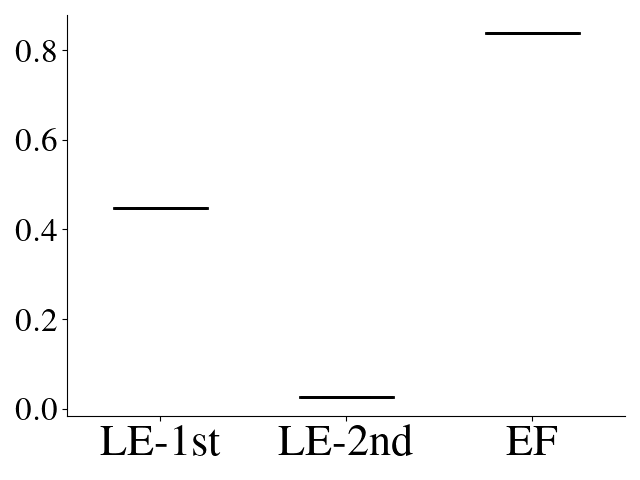

In [16]:
fig, ax = plt.subplots()
boxprops = dict(linewidth=2, facecolor='lightgray')  # No edge for the boxes
medianprops = dict(linewidth=2, color='black', linestyle='-')
whiskerprops = dict(linewidth=2, color='black', linestyle='--')  # Dashed whiskers
capprops = dict(linewidth=2, color='black')
flierprops = dict(markerfacecolor='g', marker='D')  # Green diamonds for outliers
boxplot = ax.boxplot(rmse_data, boxprops=boxprops, medianprops=medianprops,
                     whiskerprops=whiskerprops, capprops=capprops, 
                     flierprops=flierprops, patch_artist=True, widths=0.5)
colors = ['lightskyblue', 'mediumpurple', 'coral']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticks([1, 2, 3], ['LE-1st', 'LE-2nd', 'EF'], fontsize=32)
# ax.set_yticks([],fontsize=12)
ax.tick_params(axis='y', labelsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig('../media/evaluation_rmse.png', format='png', dpi=100, bbox_inches="tight")

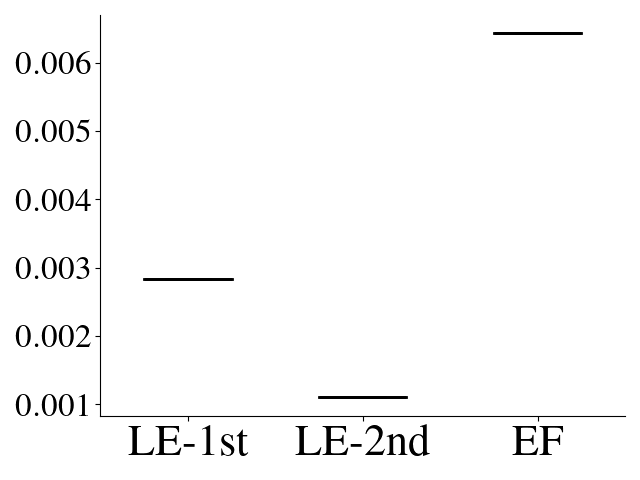

In [17]:
fig, ax = plt.subplots()
boxprops = dict(linewidth=2, facecolor='lightgray')  # No edge for the boxes
medianprops = dict(linewidth=2, color='black', linestyle='-')
whiskerprops = dict(linewidth=2, color='black', linestyle='--')  # Dashed whiskers
capprops = dict(linewidth=2, color='black')
flierprops = dict(markerfacecolor='g', marker='D')  # Green diamonds for outliers
boxplot = ax.boxplot(cos_data, boxprops=boxprops, medianprops=medianprops,
                     whiskerprops=whiskerprops, capprops=capprops, 
                     flierprops=flierprops, patch_artist=True, widths=0.5)
colors = ['lightskyblue', 'mediumpurple', 'coral']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticks([1, 2, 3], ['LE-1st', 'LE-2nd', 'EF'], fontsize=32)
# ax.set_yticks([],fontsize=12)
ax.tick_params(axis='y', labelsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig('../media/evaluation_cos.png', format='png', dpi=100, bbox_inches="tight")

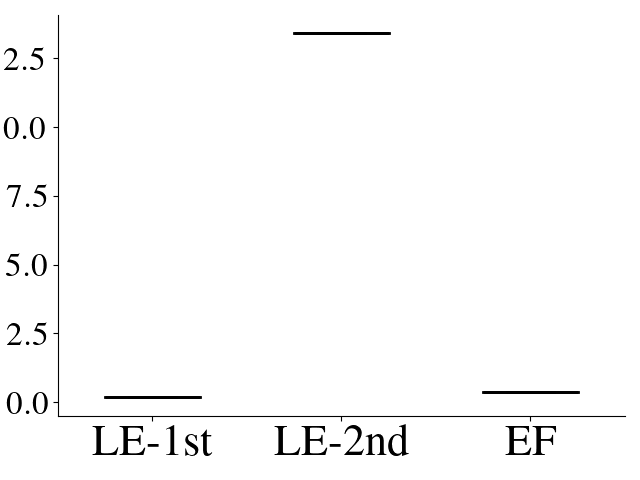

In [18]:
fig, ax = plt.subplots()
boxprops = dict(linewidth=2, facecolor='lightgray')  # No edge for the boxes
medianprops = dict(linewidth=2, color='black', linestyle='-')
whiskerprops = dict(linewidth=2, color='black', linestyle='--')  # Dashed whiskers
capprops = dict(linewidth=2, color='black')
flierprops = dict(markerfacecolor='g', marker='D')  # Green diamonds for outliers
boxplot = ax.boxplot(dtw_data, boxprops=boxprops, medianprops=medianprops,
                     whiskerprops=whiskerprops, capprops=capprops, 
                     flierprops=flierprops, patch_artist=True, widths=0.5)
colors = ['lightskyblue', 'mediumpurple', 'coral']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticks([1, 2, 3], ['LE-1st', 'LE-2nd', 'EF'], fontsize=32)
# ax.set_yticks([],fontsize=12)
ax.tick_params(axis='y', labelsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig('../media/evaluation_dtw.png', format='png', dpi=100, bbox_inches="tight")